In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import numpy as np
from numpy.linalg import qr, solve, norm
from scipy.linalg import expm


import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


class RosslerMap:
    """
    Rossler attractor
    With a=0.2, b=0.2, and c=5.7
    """

    def __init__(_, a=0.2, b=0.2, c=5.7, delta_t=1e-3):
        _.a, _.b, _.c = a, b, c
        _.delta_t = delta_t

    def v_eq(_, t=None, v=None):
        x, y, z = v[0], v[1], v[2]
        dot_x = -y - z
        dot_y = x + _.a*y
        dot_z = _.b + z*(x-_.c)
        return np.array([dot_x, dot_y, dot_z])

    def jacobian(_, v):
        x, z = v[0], v[2]
        res = np.array([[       0,      -1,       -1],
                       [        1,     _.a,        0],
                       [        z,       0,   x-_.c]])
        return res

    def full_traj(_, nb_steps, init_pos):
        t = np.linspace(0, nb_steps * _.delta_t, nb_steps)
        f = solve_ivp(_.v_eq, [0, nb_steps * _.delta_t], init_pos, method='RK45', t_eval=t)
        return np.moveaxis(f.y, -1, 0),t
    
    def equilibrium(_):
        x0 = (_.c-np.sqrt(_.c**2-4*_.a*_.b))/2
        y0 = (-_.c+np.sqrt(_.c**2-4*_.a*_.b))/(2*_.a)
        z0 = (_.c-np.sqrt(_.c**2-4*_.a*_.b))/(2*_.a)
        return np.array([x0,y0,z0])

def newton(f,jacob,x):
    #newton raphson method
    tol =1
    while tol>1e-5:
        #WARNING this is true for the jacobian of the continuous system!
        tol = x
        x = x-solve(jacob(x),f(v=x))
        tol = norm(tol-x)
    return x


equilibrium state : [ 0.0070262  -0.03513102  0.03513102] , error :  2.0811522028509542e-13


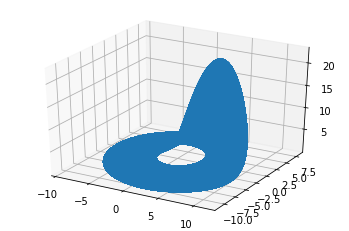

In [2]:
Niter = 2000000
delta_t = 1e-2
ROSSLER_MAP = RosslerMap(delta_t=delta_t)
INIT = np.array([-5.75, -1.6,  0.02])
traj,t = ROSSLER_MAP.full_traj(Niter, INIT)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(traj[:,0], traj[:,1], traj[:,2])

fix_point = newton(ROSSLER_MAP.v_eq,ROSSLER_MAP.jacobian,INIT)

error = norm(fix_point-ROSSLER_MAP.equilibrium())
print("equilibrium state :", fix_point, ", error : ", error)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNet1(nn.Module):
  def __init__(self):
    super(ResNet1, self).__init__()
    

    width = 30
    self.fc1 = nn.Linear(12, width)
    #self.bn1 = nn.Dropout(p=0.2)
    self.relu1 = nn.ReLU(inplace= True)
    self.fc2 = nn.Linear(width, width)
    
    self.fc3 = nn.Linear(width, width)
    #self.bn2 = nn.BatchNorm1d(10)
    self.relu2 = nn.ReLU(inplace= True)
    self.fc4 = nn.Linear(width, width)

    
    self.fc5 = nn.Linear(width, width)
    #self.bn3 = nn.Dropout(p=0.2)
    self.relu3 = nn.ReLU(inplace= True)
    self.fc6 = nn.Linear(width, width)
    
    self.fc7 = nn.Linear(width, width)
    #self.bn4 = nn.Dropout(p=0.2)
    self.relu4 = nn.ReLU(inplace= True)
    self.fc8 = nn.Linear(width, 3)

        
  def forward(self, x):
    x = self.fc1(x)
    #x = self.bn1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    #x = self.bn2(x)
    x = self.relu2(x)
    x = self.fc4(x)
    x = self.fc5(x)
    #x = self.bn3(x)
    x = self.relu3(x)
    x = self.fc6(x)
    x = self.fc7(x)
    #x = self.bn4(x)
    x = self.relu4(x)
    x = self.fc8(x)
    return x

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader

#tensor_x = torch.Tensor(np.hstack((traj[1:], traj[1:] - traj[:-1]))[:-1]) # transform to torch tensor
#tensor_y = torch.Tensor(traj[2:])

f = []
for i in range(len(traj)):
    a = traj[i]
    b = ROSSLER_MAP.jacobian(traj[i]).reshape(-1)
    f.append(np.concatenate((a,b)))
tensor_x = torch.Tensor(np.asarray(f[:-1]))
tensor_y = torch.Tensor(traj[1:])

In [5]:
model = ResNet1().to('cuda')

In [7]:
model.load_state_dict(torch.load('./model_final.pt'))

<All keys matched successfully>

In [8]:
model.eval()


output_list = []

for i in range(0, 10000, 10):
    start_point = tensor_x[i]
    output = model(start_point.cuda()).cpu().detach().numpy()
    for i in range(10):
        if i != 0:
            output = model(torch.Tensor(t1).cuda()).cpu().detach().numpy()
        t1 = np.concatenate((output, ROSSLER_MAP.jacobian(output).reshape(-1)))
        #t2 = np.concatenate((output[1], ROSSLER_MAP.jacobian(output[1]).reshape(-1)))

        #torch.Tensor([t1, t2])

        output_list.append(output)

In [9]:
output_list = np.asarray(output_list)

output_list

array([[-5.753506  , -1.6609728 ,  0.00857024],
       [-5.7631364 , -1.7227086 ,  0.00965541],
       [-5.774751  , -1.7748014 ,  0.00841184],
       ...,
       [-4.927373  , -2.9137852 ,  0.00993573],
       [-4.8872967 , -2.9309604 ,  0.01032515],
       [-4.8448625 , -2.9494872 ,  0.01074701]], dtype=float32)

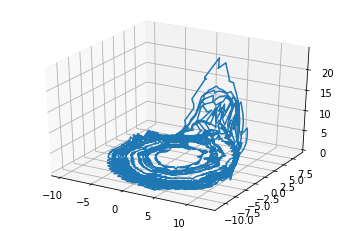

In [10]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(output_list[:,0], output_list[:,1], output_list[:,2])

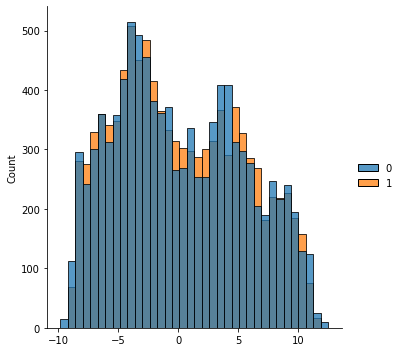

In [11]:
import seaborn as sns
sns.displot([output_list[:, 0], traj[:10000,0]])

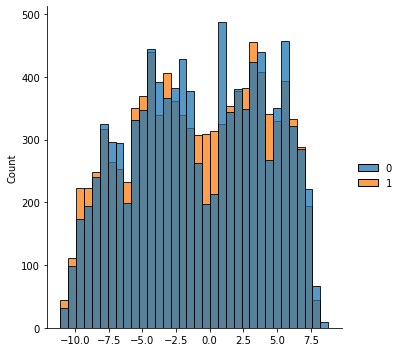

In [12]:
sns.displot([output_list[:, 1], traj[:10000,1]])

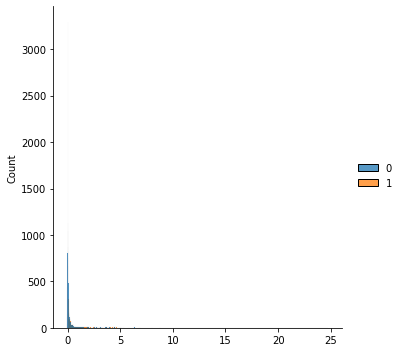

In [13]:
sns.displot([output_list[:, 2], traj[:10000,2]], kde_kws={'clip': (-10.0, 10.0)})

In [14]:
from statsmodels.tsa import stattools
print(stattools.pacf(traj[:, 1], nlags= 2))
print(stattools.pacf(output_list[:, 1], nlags= 2))

[ 1.          0.99994582 -1.00694415]
[ 1.          0.99946397 -0.04934309]


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


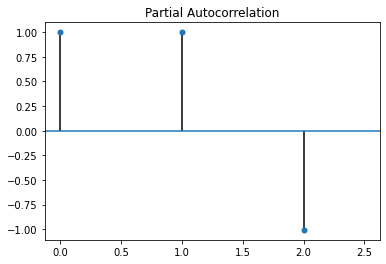

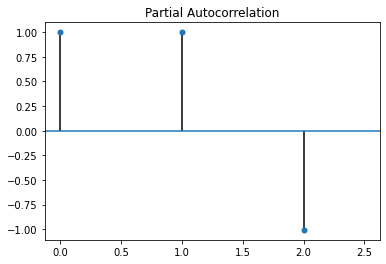

In [15]:
from statsmodels.graphics import tsaplots
tsaplots.plot_pacf(traj[:, 1], lags = 2)

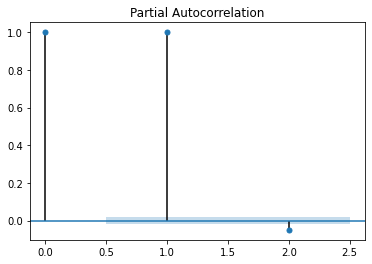

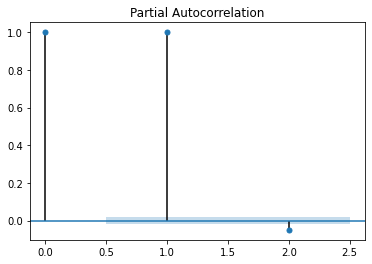

In [16]:
tsaplots.plot_pacf(output_list[:, 1], lags = 2)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


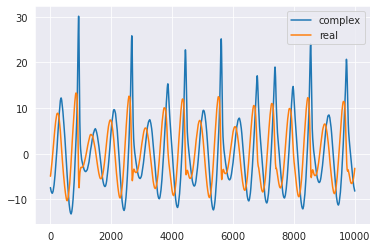

In [17]:
pred = model(tensor_x.cuda())
x = pred.cpu().detach().numpy()
fft_x = np.fft.rfft(x)

traj,t = ROSSLER_MAP.full_traj(Niter, INIT)
fft_traj = np.fft.rfft(traj)

import seaborn as sns

sns.set_style("darkgrid")
plt.plot(fft_x[:10000])
plt.legend(['complex', 'real'])
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


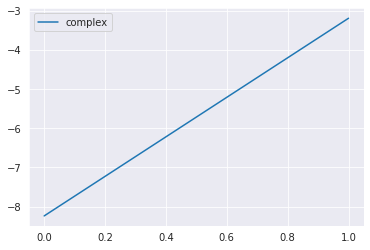

In [18]:
plt.plot(fft_traj[10000])
plt.legend(['complex', 'real'])
plt.show()